# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from skimage import exposure
from skimage.restoration import denoise_bilateral
from sklearn.decomposition import PCA

from skimage.feature import hog, local_binary_pattern
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

## **Configurazione**

In [2]:
@dataclass
class Config:
    # paths
    fit_dir  = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid"
    #fit_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/valid"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test_degradato"
    
    img_size = 128   # per HOG spesso 128 va benissimo
    random_state = 42 # tuning
    max_iter = 50000 # tuning
    
def sanity_check_paths(cfg: Config):
    for p in [cfg.fit_dir, cfg.test_dir]:
        if not os.path.exists(p):
            raise FileNotFoundError(f"Path not found: {p}")
    print("OK paths")
    print("fit_dir:", cfg.fit_dir)
    print("test_dir:", cfg.test_dir)

## **Feature Extraction**

In [ ]:
# AUG: safe per HOG/LBP 
aug_transform = transforms.Compose([
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=1.0)], p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.Resize((128, 128)),
])

def extract_feature_from_pil(pil_img: Image.Image, cfg: Config,
                            hog_conf: Dict[str, Any], lbp_conf: Dict[str, Any]) -> np.ndarray:
    pil_img = pil_img.resize((cfg.img_size, cfg.img_size)).convert("RGB")
    gray = np.array(pil_img.convert("L"))
    hog_pyr = extract_hog_pyramid(gray, hog_conf)
    lbp_pyr = extract_lbp_pyramid(gray, P=lbp_conf["P"], R=lbp_conf["R"])
    return np.concatenate([hog_pyr, lbp_pyr], axis=0).astype(np.float32)

def build_xy_with_aug(dataset, cfg, hog_conf, lbp_conf, n_aug=5, aug_transform=None):
    # originali
    X_base, y_base = build_xy(dataset, cfg, hog_conf, lbp_conf)

    # augmentate
    X_aug, y_aug = [], []
    for path, label in dataset.samples:
        img = Image.open(path).convert("RGB")
        for _ in range(n_aug):
            aug_img = aug_transform(img) if aug_transform is not None else img
            feat = extract_feature_from_pil(aug_img, cfg, hog_conf, lbp_conf)
            X_aug.append(feat)
            y_aug.append(label)

    if len(X_aug) > 0:
        X_aug = np.array(X_aug, dtype=np.float32)
        y_aug = np.array(y_aug)
        X = np.concatenate([X_base, X_aug], axis=0)
        y = np.concatenate([y_base, y_aug], axis=0)
    else:
        X, y = X_base, y_base

    return X, y

In [4]:
# =========================
# Pyramid splitting
# =========================
def split_2x2(gray: np.ndarray) -> List[np.ndarray]:
    H, W = gray.shape
    h2, w2 = H // 2, W // 2
    return [
        gray[0:h2,   0:w2],   # TL
        gray[0:h2,   w2:W],   # TR
        gray[h2:H,   0:w2],   # BL
        gray[h2:H,   w2:W],   # BR
    ]


# =========================
# HOG Pyramid (1x1 + 2x2)
# =========================
def hog_feat(gray: np.ndarray, hog_conf: Dict[str, Any]) -> np.ndarray:
    return hog(
        gray,
        orientations=hog_conf["orient"],
        pixels_per_cell=hog_conf["ppc"],
        cells_per_block=hog_conf["cpb"],
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    ).astype(np.float32)


def extract_hog_pyramid(gray: np.ndarray, hog_conf: Dict[str, Any]) -> np.ndarray:
    feats = [hog_feat(gray, hog_conf)]
    for p in split_2x2(gray):
        feats.append(hog_feat(p, hog_conf))
    return np.concatenate(feats, axis=0).astype(np.float32)


# =========================
# LBP Pyramid (1x1 + 2x2)
# =========================
def lbp_hist(gray: np.ndarray, P: int, R: int) -> np.ndarray:
    lbp = local_binary_pattern(gray, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
    hist = hist.astype(np.float32)
    hist /= (hist.sum() + 1e-6)
    return hist


def extract_lbp_pyramid(gray: np.ndarray, P: int, R: int) -> np.ndarray:
    feats = [lbp_hist(gray, P=P, R=R)]
    for p in split_2x2(gray):
        feats.append(lbp_hist(p, P=P, R=R))
    return np.concatenate(feats, axis=0).astype(np.float32)


# =========================
# Full feature: HOG pyr + LBP pyr
# =========================
def extract_feature(path: str, cfg: Config, hog_conf: Dict[str, Any], lbp_conf: Dict[str, Any]) -> np.ndarray:
    img = Image.open(path).convert("RGB").resize((cfg.img_size, cfg.img_size))
    gray = np.array(img.convert("L"))  # uint8

    hog_pyr = extract_hog_pyramid(gray, hog_conf)
    lbp_pyr = extract_lbp_pyramid(gray, P=lbp_conf["P"], R=lbp_conf["R"])

    return np.concatenate([hog_pyr, lbp_pyr], axis=0).astype(np.float32)


def build_xy(folder, cfg: Config, hog_conf: Dict[str, Any], lbp_conf: Dict[str, Any]) -> Tuple[np.ndarray, np.ndarray]:
    X, y = [], []
    for path, label in folder.samples:
        X.append(extract_feature(path, cfg, hog_conf, lbp_conf))
        y.append(label)
    return np.array(X), np.array(y)


# =========================
# Model
# =========================
def build_model(C: float, pca_n: int, solver: str="lbfgs", class_weight=None) -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=pca_n, random_state=42)),
        ("clf", LogisticRegression(
            max_iter=5000,
            C=C,
            solver=solver,
            class_weight=class_weight
        ))
    ])


## **Utils**

In [5]:
def print_top_confusions(cm: np.ndarray, class_names: List[str], top_k: int = 30):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")


def plot_cm(cm: np.ndarray, title: str):
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

## **Migliori configurazioni**

In [ ]:
# Base: prendo la migliore: HOG orient=16 + LBP P32 R4
HOG_CONF = dict(orient=16, ppc=(16, 16), cpb=(2, 2))
LBP_CONF = dict(P=32, R=4)

BEST_CONFIGS = [
    dict(tag="PCA480 C=8  lbfgs",   C=8.0,  solver="lbfgs", class_weight=None),
    dict(tag="PCA480 C=8  saga",    C=8.0,  solver="saga",  class_weight=None),
    dict(tag="PCA480 C=8  saga+bal",C=8.0,  solver="saga",  class_weight="balanced"),
    dict(tag="PCA480 C=10 saga+bal",C=10.0, solver="saga",  class_weight="balanced"),
]

## **Main**

In [7]:
cfg = Config()
np.random.seed(cfg.random_state)
sanity_check_paths(cfg)

OK paths
fit_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/valid
test_dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test_degradato


In [8]:
fit_ds  = datasets.ImageFolder(cfg.fit_dir)
test_ds = datasets.ImageFolder(cfg.test_dir)

assert fit_ds.classes == test_ds.classes, "Class order diverso tra fit e test!"
class_names = fit_ds.classes

print("Num classes:", len(class_names))
print("Fit samples:", len(fit_ds))
print("Test samples:", len(test_ds))

Num classes: 100
Fit samples: 500
Test samples: 500


In [ ]:
# migliori parametri trovati
HOG_CONF = dict(orient=16, ppc=(16, 16), cpb=(2, 2))
LBP_CONF = dict(P=32, R=4)

print("\n[FEATURE] Estrazione feature (fit)...")
# FIT con augmentation (solo fit!)
X_fit, y_fit = build_xy_with_aug(
    fit_ds, cfg, HOG_CONF, LBP_CONF,
    n_aug=5,
    aug_transform=aug_transform
)
print("[FEATURE] Estrazione feature (test)...")
# TEST mai augmentato
X_test, y_test = build_xy(test_ds, cfg, HOG_CONF, LBP_CONF)

print("X_fit shape:", X_fit.shape, "| X_test shape:", X_test.shape)


[FEATURE] Estrazione feature (fit)...
[FEATURE] Estrazione feature (test)...
X_fit shape: (3000, 5610) | X_test shape: (500, 5610)



RUN: PCA480 C=8  lbfgs
Accuracy:        0.1720
Macro-F1:        0.1706
Macro-Precision: 0.2179
Macro-Recall:    0.1720


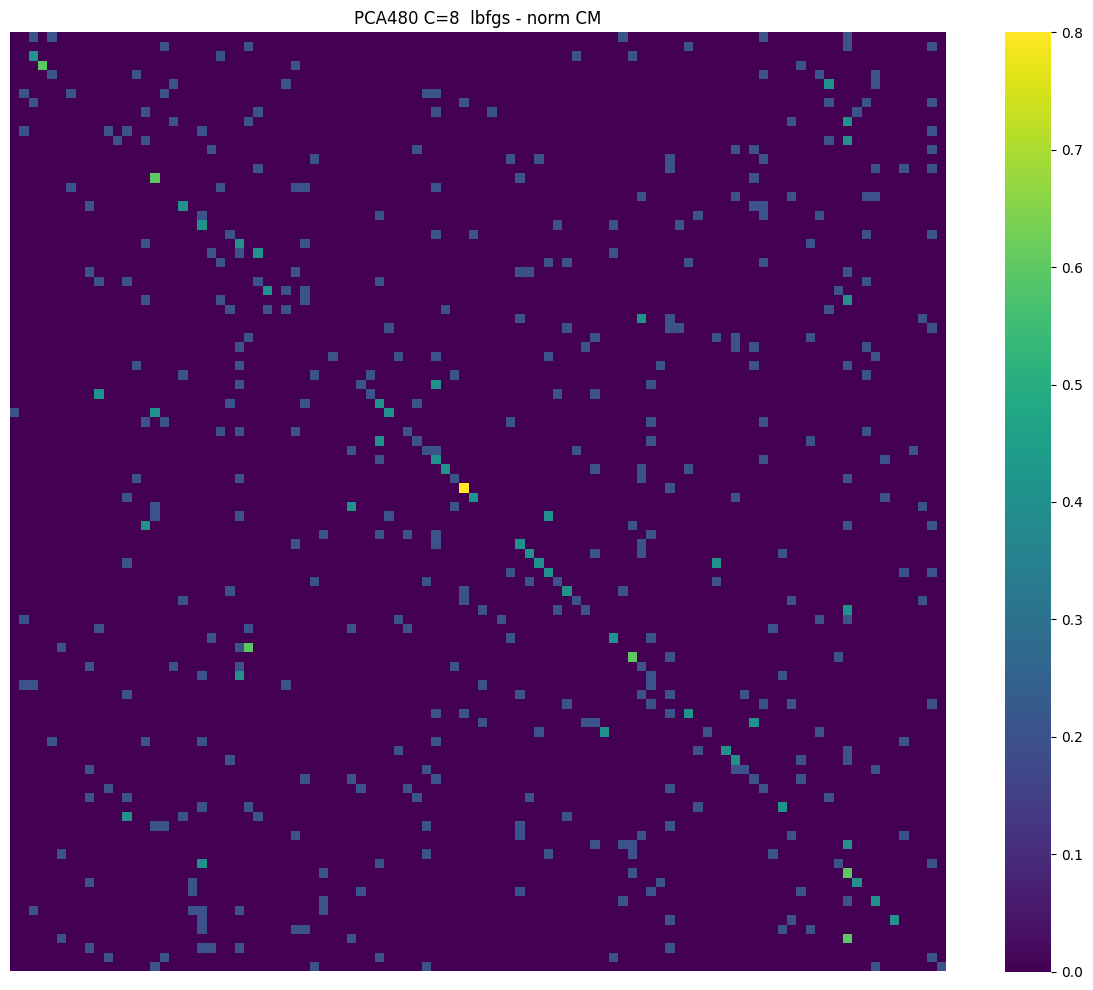


=== Top confusions: PCA480 C=8  lbfgs ===

Top 30 coppie più confuse:

pommel horse → fencing  | 3 errori
weightlifting → trapeze  | 3 errori
balance beam → tennis  | 2 errori
baton twirling → trapeze  | 2 errori
billiards → trapeze  | 2 errori
croquet → disc golf  | 2 errori
curling → field hockey  | 2 errori
figure skating pairs → trapeze  | 2 errori
fly fishing → rock climbing  | 2 errori
hammer throw → hurdles  | 2 errori
hang gliding → baton twirling  | 2 errori
high jump → boxing  | 2 errori
horse racing → harness racing  | 2 errori
javelin → golf  | 2 errori
jousting → mushing  | 2 errori
judo → bowling  | 2 errori
motorcycle racing → sidecar racing  | 2 errori
pole climbing → trapeze  | 2 errori
roller derby → disc golf  | 2 errori
shot put → snow boarding  | 2 errori
shuffleboard → pole vault  | 2 errori
sumo wrestling → bmx  | 2 errori
table tennis → trapeze  | 2 errori
track bicycle → chuckwagon racing  | 2 errori
air hockey → archery  | 1 errori
air hockey → axe throwing  

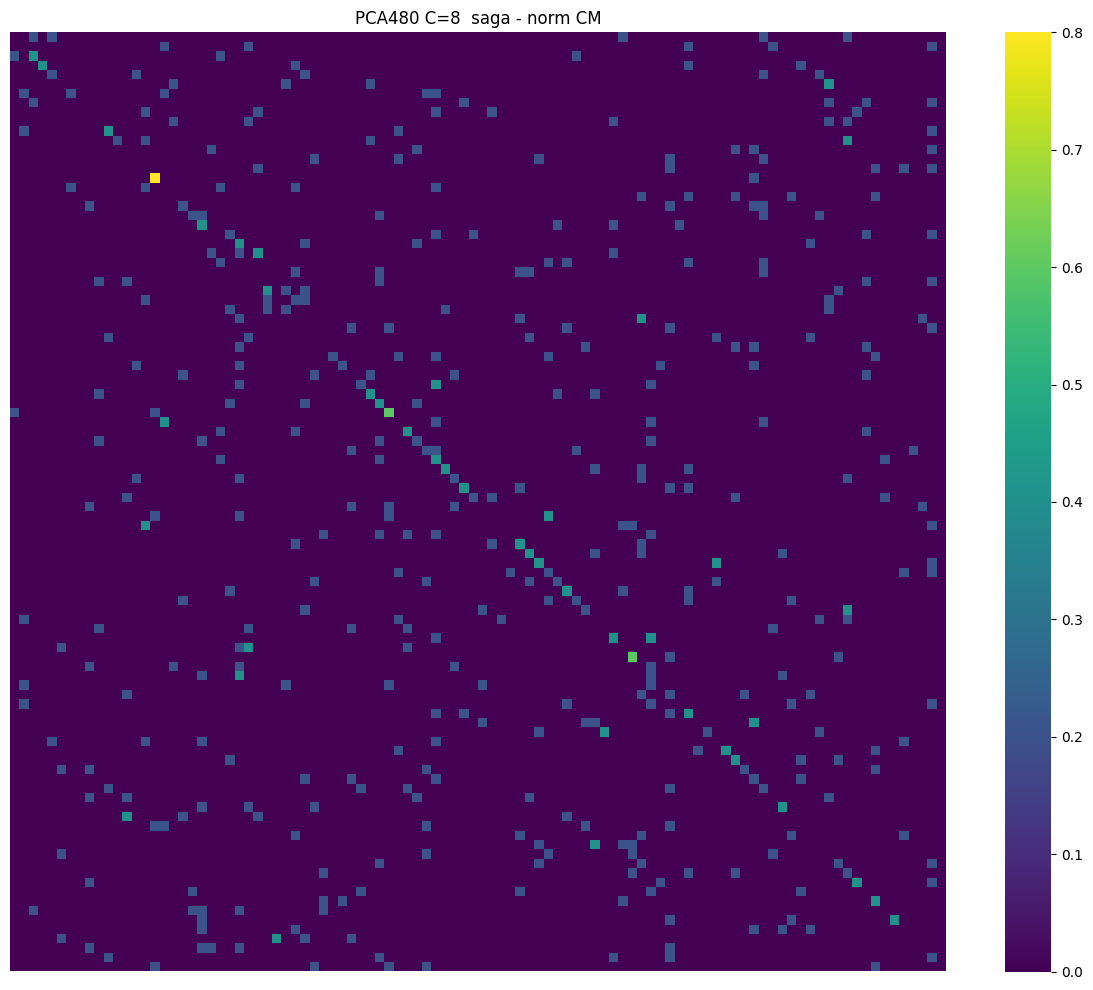


=== Top confusions: PCA480 C=8  saga ===

Top 30 coppie più confuse:

balance beam → tennis  | 2 errori
billiards → trapeze  | 2 errori
croquet → disc golf  | 2 errori
curling → field hockey  | 2 errori
fly fishing → rock climbing  | 2 errori
hammer throw → hurdles  | 2 errori
hockey → bull riding  | 2 errori
jousting → mushing  | 2 errori
judo → bowling  | 2 errori
motorcycle racing → sidecar racing  | 2 errori
pole climbing → trapeze  | 2 errori
polo → roller derby  | 2 errori
pommel horse → fencing  | 2 errori
roller derby → disc golf  | 2 errori
shot put → snow boarding  | 2 errori
shuffleboard → pole vault  | 2 errori
sumo wrestling → bmx  | 2 errori
table tennis → pole dancing  | 2 errori
weightlifting → figure skating pairs  | 2 errori
air hockey → archery  | 1 errori
air hockey → axe throwing  | 1 errori
air hockey → pommel horse  | 1 errori
air hockey → snowmobile racing  | 1 errori
air hockey → trapeze  | 1 errori
ampute football → bull riding  | 1 errori
ampute football → f

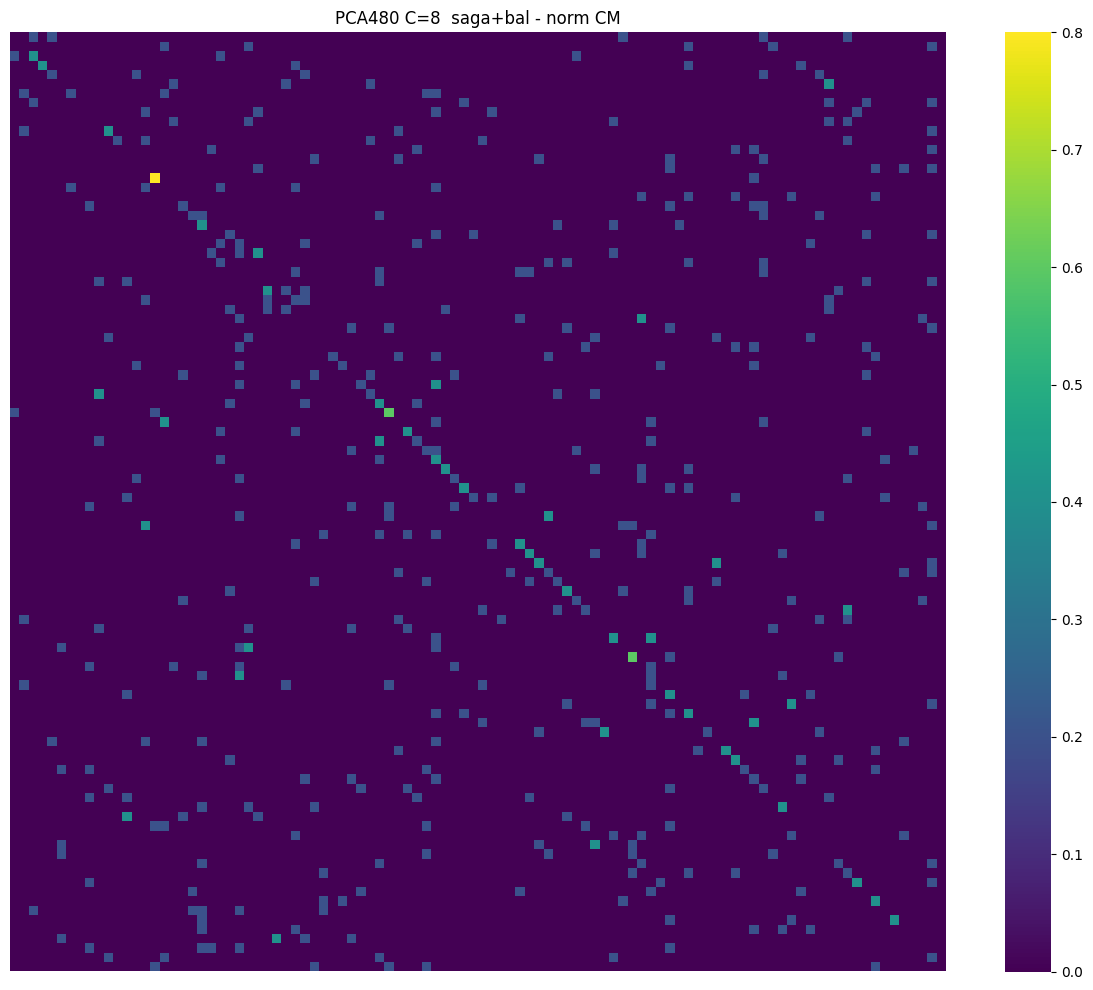


=== Top confusions: PCA480 C=8  saga+bal ===

Top 30 coppie più confuse:

balance beam → tennis  | 2 errori
curling → field hockey  | 2 errori
fly fishing → rock climbing  | 2 errori
hammer throw → hurdles  | 2 errori
hang gliding → baton twirling  | 2 errori
hockey → bull riding  | 2 errori
horse racing → harness racing  | 2 errori
jousting → mushing  | 2 errori
judo → bowling  | 2 errori
motorcycle racing → sidecar racing  | 2 errori
pole climbing → trapeze  | 2 errori
polo → roller derby  | 2 errori
pommel horse → fencing  | 2 errori
roller derby → disc golf  | 2 errori
rugby → sumo wrestling  | 2 errori
shot put → snow boarding  | 2 errori
shuffleboard → pole vault  | 2 errori
sumo wrestling → bmx  | 2 errori
table tennis → pole dancing  | 2 errori
weightlifting → figure skating pairs  | 2 errori
air hockey → archery  | 1 errori
air hockey → axe throwing  | 1 errori
air hockey → pommel horse  | 1 errori
air hockey → snowmobile racing  | 1 errori
air hockey → trapeze  | 1 errori
am

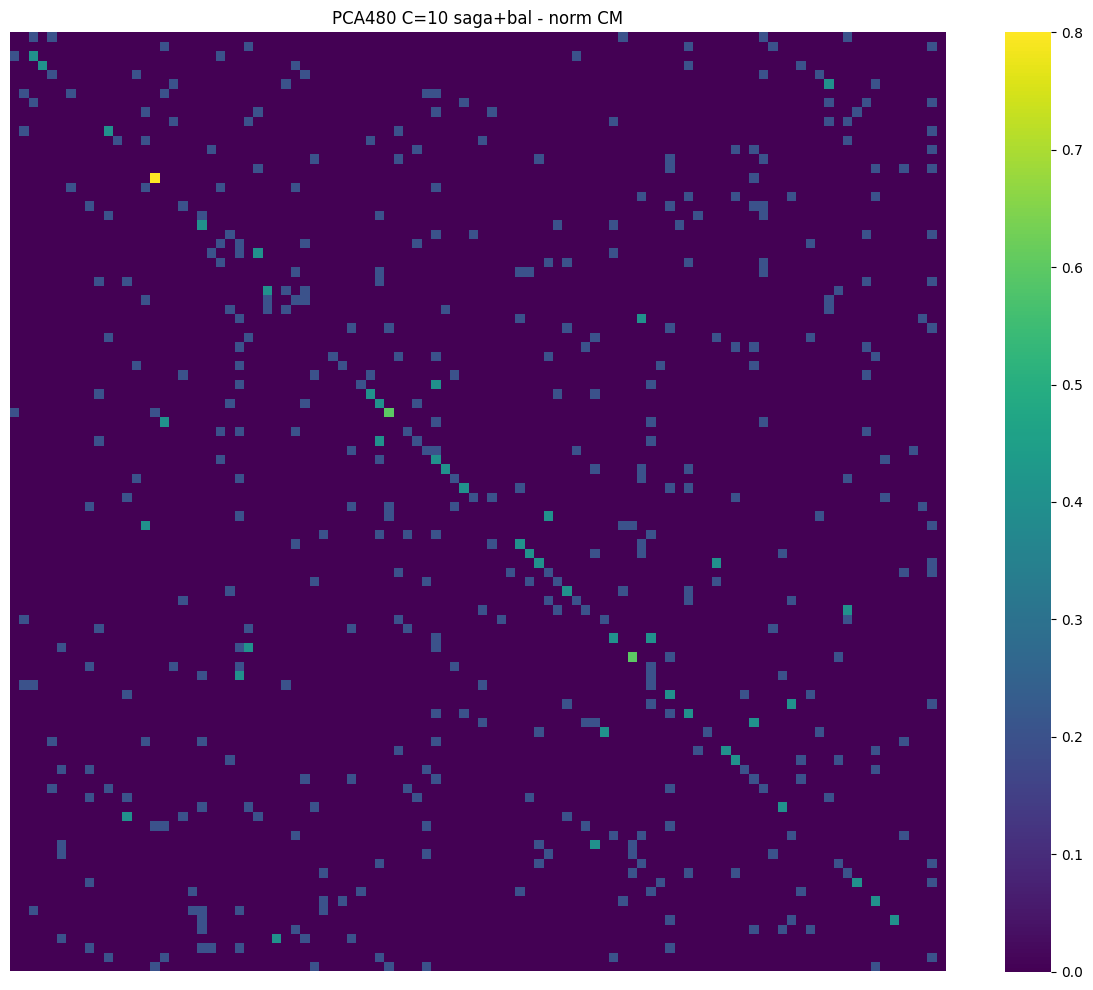


=== Top confusions: PCA480 C=10 saga+bal ===

Top 30 coppie più confuse:

balance beam → tennis  | 2 errori
curling → field hockey  | 2 errori
fly fishing → rock climbing  | 2 errori
hammer throw → hurdles  | 2 errori
hockey → bull riding  | 2 errori
horse racing → harness racing  | 2 errori
jousting → mushing  | 2 errori
judo → bowling  | 2 errori
motorcycle racing → sidecar racing  | 2 errori
pole climbing → trapeze  | 2 errori
polo → roller derby  | 2 errori
pommel horse → fencing  | 2 errori
roller derby → disc golf  | 2 errori
rugby → sumo wrestling  | 2 errori
shot put → snow boarding  | 2 errori
shuffleboard → pole vault  | 2 errori
sumo wrestling → bmx  | 2 errori
table tennis → pole dancing  | 2 errori
weightlifting → figure skating pairs  | 2 errori
air hockey → archery  | 1 errori
air hockey → axe throwing  | 1 errori
air hockey → pommel horse  | 1 errori
air hockey → snowmobile racing  | 1 errori
air hockey → trapeze  | 1 errori
ampute football → bull riding  | 1 errori
am

In [ ]:
PCA_N = 480

all_results = {}
cms = {}

for conf in BEST_CONFIGS:
    print("\n" + "="*60)
    print(f"RUN: {conf['tag']}")
    print("="*60)

    model = build_model(
        C=conf["C"],
        pca_n=PCA_N,
        solver=conf["solver"],
        class_weight=conf["class_weight"]
    )

    model.fit(X_fit, y_fit)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro", zero_division=0)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    cm  = confusion_matrix(y_test, y_pred)

    print(f"Accuracy:        {acc:.4f}")
    print(f"Macro-F1:        {f1:.4f}")
    print(f"Macro-Precision: {prec:.4f}")
    print(f"Macro-Recall:    {rec:.4f}")

    all_results[conf["tag"]] = {
        "acc": acc,
        "f1": f1,
        "prec": prec,
        "rec": rec,
        "C": conf["C"],
        "solver": conf["solver"],
        "class_weight": conf["class_weight"]
    }
    cms[conf["tag"]] = cm

    # CM e confusions per ogni run:
    plot_cm(cm, title=f"{conf['tag']} - norm CM")
    print(f"\n=== Top confusions: {conf['tag']} ===")
    print_top_confusions(cm, class_names, top_k=30)

In [11]:
print("\n" + "="*60)
print("FINAL SUMMARY (SPHOG + SP-LBP)")
print("="*60)

# stampo ordinato per F1
for tag, d in sorted(all_results.items(), key=lambda x: x[1]["f1"], reverse=True):
    print(
        f"{tag:30} | "
        f"Acc={d['acc']:.4f} | "
        f"F1={d['f1']:.4f} | "
        f"P={d['prec']:.4f} | "
        f"R={d['rec']:.4f} | "
        f"C={d['C']} | "
        f"solver={d['solver']} | "
        f"cw={d['class_weight']}"
    )


FINAL SUMMARY (SPHOG + SP-LBP)
PCA480 C=8  lbfgs              | Acc=0.1720 | F1=0.1706 | P=0.2179 | R=0.1720 | C=8.0 | solver=lbfgs | cw=None
PCA480 C=8  saga+bal           | Acc=0.1660 | F1=0.1659 | P=0.2069 | R=0.1660 | C=8.0 | solver=saga | cw=balanced
PCA480 C=8  saga               | Acc=0.1640 | F1=0.1633 | P=0.2038 | R=0.1640 | C=8.0 | solver=saga | cw=None
PCA480 C=10 saga+bal           | Acc=0.1640 | F1=0.1629 | P=0.2035 | R=0.1640 | C=10.0 | solver=saga | cw=balanced


In [12]:
y_fit_pred = model.predict(X_fit)

acc_fit = accuracy_score(y_fit, y_fit_pred)
f1_fit = f1_score(y_fit, y_fit_pred, average="macro")

print("FIT Accuracy:", acc_fit)
print("FIT F1:", f1_fit)


FIT Accuracy: 1.0
FIT F1: 1.0


## **Conclusione** 

il miglior modello:
- SPHOG (1x1+2x2) + SP-LBP (1x1+2x2)
- PCA = 480–499
- C = 8
- solver = lbfgs

con performance:

- Accuracy = 0.2060
- Macro Precision = 0.2285
- Macro Recall = 0.2060
- Macro-F1 = 0.1970